<h1>3 Python内存优化<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#使用内存分析器诊断内存" data-toc-modified-id="使用内存分析器诊断内存-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>使用内存分析器诊断内存</a></span><ul class="toc-item"><li><span><a href="#array-模块廉价地存储了许多基本对象" data-toc-modified-id="array-模块廉价地存储了许多基本对象-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>array 模块廉价地存储了许多基本对象</a></span></li><li><span><a href="#在NumPy和NumExpr中使用更少的RAM" data-toc-modified-id="在NumPy和NumExpr中使用更少的RAM-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>在NumPy和NumExpr中使用更少的RAM</a></span></li></ul></li><li><span><a href="#了解集合中使用的RAM" data-toc-modified-id="了解集合中使用的RAM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>了解集合中使用的RAM</a></span></li><li><span><a href="#字节与Unicode" data-toc-modified-id="字节与Unicode-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>字节与Unicode</a></span></li><li><span><a href="#在RAM中高效地存储大量文本" data-toc-modified-id="在RAM中高效地存储大量文本-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>在RAM中高效地存储大量文本</a></span><ul class="toc-item"><li><span><a href="#LIST" data-toc-modified-id="LIST-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LIST</a></span></li><li><span><a href="#SET" data-toc-modified-id="SET-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>SET</a></span></li><li><span><a href="#更高效的树结构" data-toc-modified-id="更高效的树结构-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>更高效的树结构</a></span><ul class="toc-item"><li><span><a href="#有向无环图" data-toc-modified-id="有向无环图-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>有向无环图</a></span></li><li><span><a href="#MARISA-TRIE" data-toc-modified-id="MARISA-TRIE-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>MARISA TRIE</a></span></li><li><span><a href="#在生产系统中使用TRIES（和DAWG）" data-toc-modified-id="在生产系统中使用TRIES（和DAWG）-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>在生产系统中使用TRIES（和DAWG）</a></span></li></ul></li></ul></li><li><span><a href="#使用-Scikit-Learn-的-FeatureHasher-建模更多文本" data-toc-modified-id="使用-Scikit-Learn-的-FeatureHasher-建模更多文本-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>使用 Scikit Learn 的 FeatureHasher 建模更多文本</a></span><ul class="toc-item"><li><span><a href="#介绍DictVectorizer和FeatureHasher" data-toc-modified-id="介绍DictVectorizer和FeatureHasher-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>介绍DictVectorizer和FeatureHasher</a></span></li><li><span><a href="#比较DictVectorizer和FeatureHasher" data-toc-modified-id="比较DictVectorizer和FeatureHasher-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>比较DictVectorizer和FeatureHasher</a></span></li></ul></li><li><span><a href="#SciPy稀疏矩阵" data-toc-modified-id="SciPy稀疏矩阵-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>SciPy稀疏矩阵</a></span></li><li><span><a href="#使用更少内存的技巧" data-toc-modified-id="使用更少内存的技巧-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>使用更少内存的技巧</a></span></li><li><span><a href="#研究项目：概率数据结构" data-toc-modified-id="研究项目：概率数据结构-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>研究项目：概率数据结构</a></span></li><li><span><a href="#思考题" data-toc-modified-id="思考题-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>思考题</a></span></li></ul></div>

在内存用完之前，我们很少考虑使用了多少内存。如果在扩展代码时用完了，它可能会成为一个突然的拦路虎。在一台机器的RAM中安装更多的内存意味着要管理的机器更少，它为您规划更大项目的容量提供了一条途径。了解RAM被耗尽的原因，并考虑更有效的方法来使用这一稀缺资源，将有助于处理扩展问题。我们将使用 Memory Profiler 和 iPython Memory Usage 工具来测量实际的RAM使用情况，同时还将使用一些工具来内省对象以尝试猜测它们使用了多少RAM。

另一种保存RAM的方法是使用容器来利用数据中的特性进行压缩。在本节中，我们将介绍 Trie（有序树数据结构）和有向无环图（DAWG），它可以将1.2GB的字符串集压缩到30MB，而性能几乎没有变化。第三种方法是用存储来换取准确性。为此，我们将研究近似计数和近似集成员关系，它们使用的内存比精确对应的内存少得多。

RAM使用的一个考虑因素是“数据有质量”的概念。数据越多，移动越慢。如果在使用RAM时可以节省开支，那么数据可能会消耗得更快，因为它在总线上的移动速度更快，而且更多的数据将放入受约束的缓存中。如果需要将其存储在脱机存储中（例如，硬盘驱动器或远程数据集群），它将以更慢的速度移动到您的计算机。尽量选择合适的数据结构，这样所有的数据都可以放在一台机器上。我们将使用 NumExpr 高效地使用 NumPy 和 Pandas 进行计算，与更直接的方法相比，数据移动更少，这将节省我们的时间，并使某些更大的计算在固定数量的RAM中可行。

计算Python对象所使用的RAM数量是非常棘手的。我们不一定知道一个对象在幕后是如何表示的，如果我们询问操作系统使用的字节数，它会告诉我们分配给进程的总量。在这两种情况下，我们无法确切地看到每个Python对象是如何添加到总数中的。

由于某些对象和库不报告其完整的内部字节分配（或者它们包装根本不报告其分配的外部库），因此这必须是最佳猜测的情况。本节中探讨的方法可以帮助我们确定表示数据的最佳方式，从而减少总体RAM的使用。

我们还将介绍几种有损方法，用于在 scikit-learn 中存储字符串，并在数据结构中存储计数。它的工作原理有点像JPEG压缩的图像，我们丢失了一些信息（我们无法撤消恢复它的操作），因此我们获得了大量的压缩。通过在字符串上使用哈希，我们压缩了 scikit-learn 中自然语言处理任务的时间和内存使用量，并且我们可以用少量的RAM来计算大量的事件。

# 使用内存分析器诊断内存

通常使用列表这样的容器，存储成百上千个项。一旦存储了大量数据，RAM的使用就成了一个问题。

如果项是同一个对象，则包含1亿个项的列表将消耗大约760MB的RAM。如果我们存储1亿个不同的项（例如，唯一整数），我们可以预期使用千兆字节的RAM！每个唯一的对象都有一个内存开销。

在下面的示例中，我们在一个列表中存储许多0整数。如果存储了对任何对象的1亿个引用（不管该对象的一个实例有多大），仍然希望看到大约760MB的内存开销，因为列表存储的是对该对象的引用（而不是副本）。在这里，我们使用 `%load_ext memory_profiler` 将它作为一个新的魔法函数加载到IPython中。

例：在一个列表中测量1亿个相同整数的内存使用率

In [1]:
!pip  install  memory_profiler --user

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [2]:
%load_ext memory_profiler

In [3]:
%memit [0] * int(1e8)

peak memory: 819.44 MiB, increment: 764.65 MiB


对于下一个示例，我们将从一个新的shell开始。作为示例中第一次调用 memit 的结果如下图所示，一个新的IPython外壳消耗大约40MB的内存。接下来，我们可以创建一个包含1亿个唯一数字的临时列表。总共大约消耗3.8 GB。

memit 命令完成后，临时列表被释放。对 memit 的最后一次调用表明内存使用量下降到了以前的水平。

例:测量列表中1亿个不同整数的内存使用情况

In [1]:
%load_ext memory_profiler

In [2]:
%memit # show how much RAM this process is consuming right now

peak memory: 54.88 MiB, increment: 0.25 MiB


In [3]:
%memit [n for n in range(int(1e8))]

peak memory: 4426.79 MiB, increment: 4371.89 MiB


In [4]:
%memit

peak memory: 56.64 MiB, increment: 0.00 MiB


下面示例中的后续 memit ,创建第二个1亿个项目列表再次消耗大约3.8 GB。

例：再次测量列表中1亿个不同整数的内存使用情况

In [5]:
%memit [n for n in range(int(1e8))]

peak memory: 4455.56 MiB, increment: 4398.91 MiB


接下来，我们将看到，我们可以使用 array 模块来存储1亿个整数，这要便宜得多。

## array 模块廉价地存储了许多基本对象

array 模块有效地存储诸如整数、浮点和字符之类的基本类型，但不存储复数或类。它创建一个连续的RAM块来保存底层数据。

在下面示例中，我们将1亿个整数（每个8字节）分配到一个连续的内存块中。该进程总共消耗了大约760 MB。此方法与以前的唯一整数列表方法之间的差异是3100MB-760MB==2.3GB。这是一个巨大的节省内存。

例：用760MB内存构建1亿个整数的数组

In [1]:
%load_ext memory_profiler

In [2]:
import array

In [3]:
%memit array.array('l', range(int(1e8)))

peak memory: 793.96 MiB, increment: 739.28 MiB


In [4]:
arr = array.array('l')

In [5]:
arr.itemsize

4

array 模块使用有限的一组精度不同的数据类型（参见下面示例). 选择需要的最小精度，这样就可以根据需要分配同样多的RAM，而不需要更多。请注意，字节大小取决于平台，这里的大小指的是32位平台（它表示最小大小），而我们在64位笔记本电脑上运行这些示例。

例：数组模块提供的基本类型

In [6]:
array.array?

NumPy 的数组可以容纳更广泛的数据类型，可以更好地控制每个项的字节数，并且可以使用复数和 datetime 对象。complex128 对象每项占用16字节：每项是一对8字节的浮点数。不能将复杂对象存储在Python数组中，但是numpy免费提供这些对象。

在下面示例中，可以看到 numpy 数组的另一个特性；可以查询项的数量、每个原语的大小以及RAM底层块的总存储空间。请注意，这不包括Python对象的开销（通常，与存储在数组中的数据相比，这个开销很小）。

例：在numpy数组中存储更复杂的类型

In [1]:
%load_ext memory_profiler

In [2]:
import numpy as np

In [3]:
# NOTE that zeros have lazy allocation so misreport the memory used!
%memit arr=np.zeros(int(1e8), np.complex128)

peak memory: 63.86 MiB, increment: 0.29 MiB


In [4]:
%memit arr=np.ones(int(1e8), np.complex128)

peak memory: 1592.79 MiB, increment: 1528.89 MiB


In [5]:
f"{arr.size:,}"

'100,000,000'

In [6]:
f"{arr.nbytes:,}"

'1,600,000,000'

In [7]:
arr.nbytes/arr.size

16.0

In [8]:
arr.itemsize

16

在RAM中，使用常规列表存储许多数字比使用 array 对象效率要低得多。必须进行更多的内存分配，每次都需要时间；计算也发生在更大的对象上，这对缓存不太友好，而且总体上使用了更多的RAM，因此其他程序可用的RAM更少。

但是，如果在 Python NumExpr 中对数组的内容进行任何操作，那么很可能会转换为临时对象，从而抵消了它们的好处。在与其他进程通信时将它们用作数据存储是 array 的一个很好的用例。

Numpy array几乎可以肯定是一个更好的选择，如果你正在做任何严重的数字，因为你得到更多的数据类型选项和许多专门和快速的函数。如果希望减少项目的依赖项，可以选择避免Numpy，尽管Cython对array和Numpy数组同样适用；Numba仅适用于Numpy数组。

Python提供了一些其他工具来了解内存使用情况，我们将在下一节中看到。

## 在NumPy和NumExpr中使用更少的RAM

NumPy 中的大型矢量化表达式（也发生在Pandas中的幕后）可以在复杂操作期间创建中间大型数组。这些错误是不可见的，只有在发生内存不足错误时才会引起注意。这些计算也可能很慢，因为大向量不利于缓存——缓存可以是兆字节或更小，而数百兆字节或千兆字节数据的大向量将阻止缓存的有效使用。NumExpr 是一种既能加速中间操作又能减小中间操作大小的工具；我们在上一节“Numexpr：使 in-place 操作更快更容易”中介绍了它。

前面，我们介绍了内存分析器。在这里，我们使用IPython内存使用工具来构建它，它可以逐行报告IPython shell 或 Jupyter Notebook 中的内存更改。

让我们看看如何使用这些来检查 NumExpr 是否更有效地生成结果？

我们将使用交叉熵公式来计算机器学习分类的误差。交叉熵（或对数损失）是分类的常用度量；它对大错误的惩罚明显大于对小错误的惩罚。机器学习问题中的每一行都需要在训练和预测阶段进行评分：

$$-logP(y_t|y_p) = -(y_tlog(y_p))+(1-y_t)log(1-y_p)$$

我们将在这里使用[0，1]范围内的随机数来模拟来自诸如scikit-learn或TensorFlow之类的包的机器学习系统的结果。下图1右边显示范围[0，1]的自然对数，在左边显示计算目标为0或1时任何概率的交叉熵的结果。

如果目标$y_t$为1，则公式的前半部分是活动的，后半部分变为零。如果目标为0，则公式的后半部分处于活动状态，第一部分变为0。对于每一行需要评分的数据，以及机器学习算法的多次迭代，都会计算出这个结果。

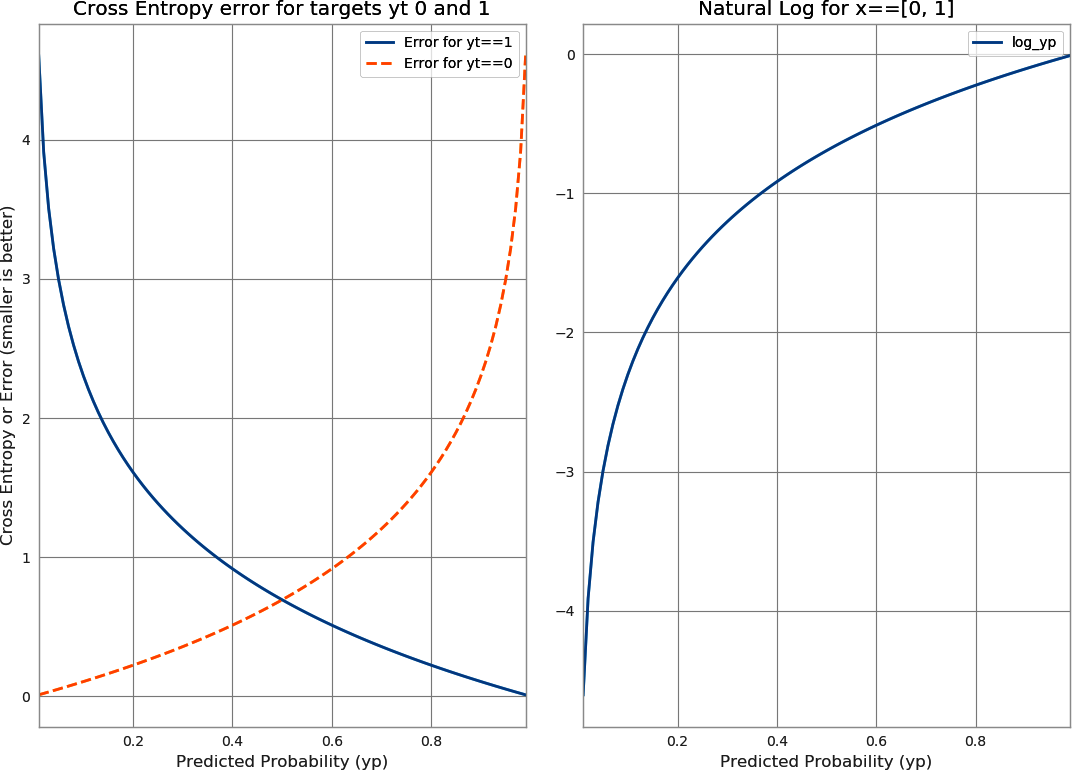

值为0和1的$y_t$的交叉熵（“真值”）

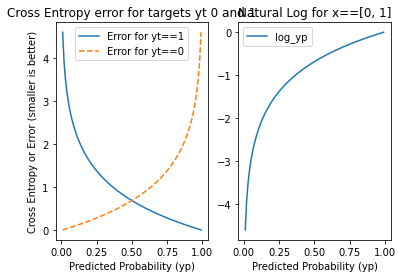

In [4]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
#nbr_items = 200_000_000

nbr_items = 99
yp = np.linspace(0.01, 0.99, nbr_items)
yt = np.ones(nbr_items)
answer = -(yt * np.log(yp) + ((1-yt) * (np.log(1-yp))))

yt0 = np.zeros(nbr_items)
answer0 = -(yt0 * np.log(yp) + ((1-yt0) * (np.log(1-yp))))

df = pd.DataFrame({'yp': yp, 'yt': yt, 'cross_entropy': answer, 'cross_entropy0': answer0})

fig, axs = plt.subplots(ncols=2)
ax = axs[0]
df.plot(x='yp', y='cross_entropy', ax=ax, label='Error for yt==1')
df.plot(x='yp', y='cross_entropy0', ax=ax, label='Error for yt==0', linestyle='--')
ax.set_ylabel('Cross Entropy or Error (smaller is better)')
ax.set_xlabel('Predicted Probability (yp)')
ax.set_title('Cross Entropy error for targets yt 0 and 1')

ax = axs[1]
logs = np.log(yp)
df_log = pd.DataFrame({'yp': yp, 'log_yp': logs})
df_log.plot(x='yp', y='log_yp', ax=ax)
ax.set_title('Natural Log for x==[0, 1]')
ax.set_xlabel('Predicted Probability (yp)')
plt.show()
# plt.tight_layout()
# plt.savefig('cross_entropy.png')

在下面示例中，我们生成2亿个在[0，1]范围内的随机数作为$y_p$。在这个例子中，$y_t$是期望的真值，一个1的数组。在实际应用中，我们会看到机器学习算法生成的$y_p$，而$y_t$将是机器学习研究人员提供的混合0和1的基本真值。

例：具有大NumPy数组的临时变量的隐藏代价

In [1]:
import ipython_memory_usage.ipython_memory_usage as imu; import numpy as np

In [2]:
%ipython_memory_usage_start

'memory profile enabled'

In [2] used 11.4414 MiB RAM in 3.87s, peaked 0.00 MiB above current, total RAM usage 64.58 MiB


In [3]:
nbr_items = 200_000_000

In [3] used 0.1094 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 64.69 MiB


In [4]:
yp = np.random.uniform(low=0.0000001, size=nbr_items)

In [4] used 1528.9297 MiB RAM in 3.31s, peaked 0.00 MiB above current, total RAM usage 1593.62 MiB


In [5]:
yt = np.ones(shape=nbr_items)

In [5] used 1528.8867 MiB RAM in 0.62s, peaked 0.00 MiB above current, total RAM usage 3122.50 MiB


In [6]:
answer = -(yt * np.log(yp) + ((1-yt) * (np.log(1-yp))))

In [6] used 1528.9883 MiB RAM in 12.50s, peaked 4578.20 MiB above current, total RAM usage 4651.49 MiB


In [7]:
del answer

In [7] used -1528.8594 MiB RAM in 0.27s, peaked 0.00 MiB above current, total RAM usage 3122.63 MiB


yp和yt各占用1.5 GB，使RAM的总使用量略高于3.1 GB。答案向量的维数与输入相同，因此又增加了1.5 GB。请注意，在当前RAM使用情况下，计算峰值为4.5 GB，因此虽然我们以4.6 GB的结果结束，但在计算期间分配了超过9 GB的内存。交叉熵计算创建了几个临时变量（特别是1–yt、np.log（1–yp）和它们的乘法）。如果你有一台8GB的机器，你会因为内存耗尽而无法计算这个结果。

在下面示例中，我们在 `numexpr.evaluate` 中看到了作为字符串放置的相同表达式。它的峰值比当前使用量高出0GB，在这种情况下不需要任何额外的RAM。值得注意的是，它的计算速度也要快得多：前面的直接向量计算需要12.50秒，而在这里使用NumExpr时，相同的计算需要1.22秒。

NumExpr将长向量分解为较短的、对缓存友好的块，并对每个块进行串行处理，因此以对缓存友好的方式计算结果的局部块。这说明了不需要额外的RAM和提高的速度。

In [9]:
! pip install numexpr

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
In [9] used 0.0742 MiB RAM in 9.22s, peaked 0.02 MiB above current, total RAM usage 3123.41 MiB


例:NumExpr将矢量化计算分解为缓存效率高的块

In [10]:
import numexpr

In [10] used 0.5352 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 3123.95 MiB


In [11]:
answer = numexpr.evaluate("-(yt * log(yp) + ((1-yt) * (log(1-yp))))")

In [11] used 1529.0938 MiB RAM in 1.22s, peaked 0.00 MiB above current, total RAM usage 4653.04 MiB


我们可以在Pandas身上看到类似的好处。我们使用与前面示例中相同的项构造数据帧，并使用 `df.eval` 调用 NumExpr。Pandas机器需要为 NumExpr 解包数据帧，并且总体上使用了更多的RAM；在幕后，NumExpr 仍然以缓存友好的方式计算结果。请注意，这里除了安装Pandas外，还安装了NumExpr。

例:Pandas eval使用NumExpr（如果可用）

In [12]:
import pandas as pd

df = pd.DataFrame({'yp': np.random.uniform(low=0.0000001, size=nbr_items),
       'yt': np.ones(nbr_items)})

In [12] used 3079.5781 MiB RAM in 6.38s, peaked 2972.10 MiB above current, total RAM usage 7732.62 MiB


In [13]:
answer_eval = df.eval("-(yt * log(yp) + ((1-yt) * (log(1-yp))))")

In [13] used 3058.1484 MiB RAM in 3.00s, peaked 2905.54 MiB above current, total RAM usage 10790.77 MiB


对比一下，其中NumExpr尚未安装。对df.eval的调用返回到Python解释器上，计算出相同的结果，但执行时间为3.00秒（与之前的12.50秒相比），峰值内存使用量要大得多。可以测试NumExpr是否与import NumExpr一起安装，如果失败，将需要重新安装它。

例:注意，没有NumExpr的Pandas给eval调用缓慢而昂贵

In [14]:
df = pd.DataFrame({'yp': np.random.uniform(low=0.0000001, size=nbr_items),
       'yt': np.ones(nbr_items)})

In [14] used -0.0039 MiB RAM in 5.95s, peaked 5866.82 MiB above current, total RAM usage 10790.77 MiB


In [15]:
answer_eval = df.eval("-(yt * log(yp) + ((1-yt) * (log(1-yp))))")

In [15] used 0.0469 MiB RAM in 3.22s, peaked 6096.33 MiB above current, total RAM usage 10790.81 MiB


如果可以使用 NumExpr，那么在大型数组上的复杂向量操作将运行得更快。Pandas 不会警告尚未安装 NumExpr，因此如果使用 eval，建议将其添加为安装程序的一部分。如果有RAM正在处理大的 array,IPython内存使用工具将帮助诊断,这可以帮助在当前机器的RAM中容纳更多的内存，这样就不必开始分割数据和引入更大的工程工作。

# 了解集合中使用的RAM

可能想知道是否可以向Python询问每个对象使用的RAM。Python的 `sys.getsizeof（obj）` 调用将告诉我们一些关于对象使用的内存的信息（大多数但不是所有的对象都提供这种信息）。如果以前没有见过它，请注意它不会给你一个容器的答案！

让我们先看看一些基本类型。Python中的 int 是任意大小的可变大小的对象，远高于8字节C整数的范围。在python3.7中，当用0初始化时，基本对象需要24字节。当计数到较大的数字时，会添加更多的字节：

In [16]:
import sys

sys.getsizeof(0)

24

In [16] used 0.0039 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.82 MiB


In [17]:
sys.getsizeof(1)

28

In [17] used 0.0039 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.82 MiB


In [18]:
sys.getsizeof((2**30)-1)

28

In [18] used 0.0117 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 10790.83 MiB


In [19]:
sys.getsizeof((2**30))

32

In [19] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 10790.83 MiB


在幕后，每次正在计算的数字的大小超过上一个限制时，都会添加4个字节的集合。这只影响内存使用；看不出外部有什么不同。

我们可以对字节字符串做同样的检查。一个空字节序列需要33个字节，每增加一个字符就增加1个字节：

In [20]:
sys.getsizeof(b"")

33

In [20] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.84 MiB


In [21]:
sys.getsizeof(b"a")

34

In [21] used 0.0156 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.86 MiB


In [22]:
sys.getsizeof(b"ab")

35

In [22] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 10790.86 MiB


In [23]:
sys.getsizeof(b"abc")

36

In [23] used 0.0156 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.87 MiB


当我们使用列表时，我们会看到不同的行为。getsizeof不计算列表内容的成本，只计算列表本身的成本。一个空列表需要64字节，而在64位笔记本电脑上，列表中的每一项又需要8字节：

In [24]:
# goes up in 8-byte steps rather than the 24+ we might expect!
sys.getsizeof([])

64

In [24] used 0.0039 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.88 MiB


In [25]:
sys.getsizeof([1])

72

In [25] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.88 MiB


In [26]:
sys.getsizeof([1, 2])

80

In [26] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.89 MiB


如果我们使用字节字符串，这一点就更加明显了，我们希望看到的成本比getsizeof报告的要大得多：

In [27]:
sys.getsizeof([b""])

72

In [27] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.89 MiB


In [28]:
sys.getsizeof([b"abcdefghijklm"])

72

In [28] used -0.0039 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.89 MiB


In [29]:
sys.getsizeof([b"a", b"b"])

80

In [29] used 0.0039 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 10790.89 MiB


getsizeof 只报告部分开销，而且通常只针对父对象。如前所述，它也不总是实现的，所以它的用处有限。

Pypler 中有一个更好的工具。这将遍历容器的层次结构，并对找到的每个对象的大小进行最佳猜测，将大小添加到总数中。请注意，这是相当缓慢的。

除了依赖猜测和假设之外，asizeof 还不能计算幕后分配的内存（例如包装C库的模块可能不会报告C库中分配的字节）。最好以此为指导。我们更喜欢使用memit，因为它能让我们准确地计算出机器上的内存使用情况。

我们可以检查它对一个大列表的估计，这里我们将使用1000万个整数：

In [9]:
! pip install pympler

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [1]:
%load_ext memory_profiler

In [2]:
from pympler.asizeof import asizeof

In [3]:
asizeof([x for x in range(int(1e7))])

401528048

In [4]:
%memit [x for x in range(int(1e7))]

peak memory: 437.81 MiB, increment: 372.14 MiB


我们可以通过使用memit来验证这个估计，看看这个过程是如何发展的。这两个报告都是近似的memit在执行语句时拍摄操作系统报告的RAM使用情况的快照，asizeof询问对象的大小（可能没有正确报告）。我们可以得出结论，一个列表中的1000万个整数需要320到400 MB的RAM。

一般来说，asizeof进程比使用memit慢，但是asizeof在分析小对象时非常有用。memit对于实际应用程序可能更有用，因为进程的实际内存使用情况是测量的，而不是推断的。

# 字节与Unicode

与Python2.x相比，Python3.x的优点是默认情况下切换到Unicode。以前，我们混合使用单字节字符串和多字节Unicode对象，这可能会在数据导入和导出过程中造成麻烦。在Python3.x中，默认情况下，所有字符串都是Unicode的，如果您想以字节为单位处理，那么将显式地创建一个字节序列。

Unicode对象在Python3.7中比在Python2.x中更有效地使用RAM。在下面示例中，我们可以看到一个一亿字符的序列被构建为一个字节集合和一个Unicode对象。通用字符的Unicode变体（这里我们假设utf8是系统的默认编码）的成本是相同的，这些通用字符使用单字节实现。

例：Unicode对象可以像Python3.x中的字节一样便宜

In [5]:
%load_ext memory_profiler

In [6]:
type(b"b")

bytes

In [7]:
%memit b"a" * int(1e8)

peak memory: 114.54 MiB, increment: 58.28 MiB


In [9]:
type("u")

str

In [10]:
%memit "u" * int(1e8)

peak memory: 140.41 MiB, increment: 83.82 MiB


In [11]:
%memit "Σ" * int(1e8)

peak memory: 241.42 MiB, increment: 184.84 MiB


西格玛字符(Σ) 它在utf8中表示为2字节。得益于 PEP393，我们从python3.3获得了灵活的Unicode表示。它的工作原理是观察字符串中字符的范围，如果可能的话，使用较小的字节数来表示低阶字符。

Unicode对象的UTF-8编码对每个ASCII字符使用1个字节，对不常见的字符使用更多字节。如果你不确定Unicode编码和Unicode对象的区别，那就去看看Net Batchelder的“实用的Unicode，或者，我该如何停止痛苦？”。

# 在RAM中高效地存储大量文本

文本的一个常见问题是它占用了大量的RAM，但是如果我们想测试之前是否见过字符串或者计算它们的频率，那么将它们放在RAM中要比在磁盘上来回分页方便得多。单纯地存储字符串是昂贵的，但是 Tries 和有向无环字图（DAWG）可以用来压缩它们的表示，并且仍然允许快速操作。

这些更高级的算法可以为节省大量的RAM，这意味着可能不需要扩展到更多的服务器。对于生产系统来说，节省的成本是巨大的。在本节中，我们将研究如何使用 Trie 将一组成本为1.2GB的字符串压缩到30MB，而性能只有一点变化。

对于这个例子，我们将使用从Wikipedia的部分转储构建的文本集。这个集合包含来自英文维基百科一部分的1100万个独特的分词，在磁盘上占用120MB。
分词是从他们原来的文章中分离出来的；它们的长度可变，并且包含 Unicode 字符和数字。它们看起来像这样：

我们将使用这个文本示例来测试构建包含每个唯一单词的一个实例的数据结构的速度，然后看看查询已知单词的速度有多快（我们将使用画家 `Alfred Zwiebel` 的不常见的 `Zwiebel`）。这让我们可以问，“我们以前见过 `Zwiebel` 吗？”分词查找是一个常见的问题，能够快速地完成它非常重要。

##### 在1100万个分词上尝试这些方法

下图显示了1100万个分词文本文件（120MB原始数据），这些文件使用了我们将在本节中讨论的许多容器来存储。x轴显示每个容器的RAM使用情况，y轴跟踪查询时间，每个点的大小与构建结构所花费的时间有关（越大意味着所花费的时间越长）。

如图所示，集合和列表示例使用了大量RAM；列表示例既大又慢！对于这个数据集，Marisa-Trie的例子是RAM效率最高的，而DAWG的运行速度是RAM使用率相对较小的两倍。

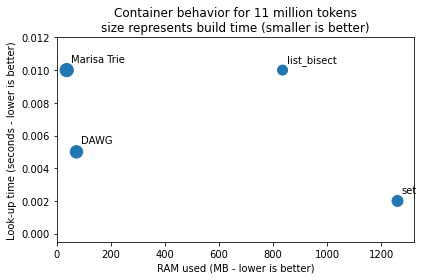

In [6]:
import matplotlib.pyplot as plt


labels = ['list_bisect', 'set', 'Marisa Trie', 'DAWG']
ram_used = [835, 1260, 37, 73]
build_time = [20, 24, 35, 31]
lookup_time = [0.01, 0.002, 0.01, 0.005]

#labels = ['list_bisect', 'set', 'Marisa Trie', 'DAWG', 'HAT Trie']
#ram_used = [920, 1112, 293, 958, 244]
#build_time = [47, 31, 55, 63, 44]
#lookup_time = [0.02, 0.003, 0.01, 0.004, 0.005]

# make the build-time circles much larger
build_time = [bt * 5 for bt in build_time]

plt.figure(1)
plt.clf()
plt.scatter(ram_used, lookup_time, s=build_time)

for ram, lookup, label in zip(ram_used, lookup_time, labels):
    plt.annotate(label, (ram+15, lookup+0.0005))

plt.xlabel('RAM used (MB - lower is better)')
plt.ylabel("Look-up time (seconds - lower is better)")
plt.title("Container behavior for 11 million tokens\nsize represents build time (smaller is better)")
plt.xlim(xmin=0)
plt.ylim((-0.0005, 0.012))
plt.tight_layout()
plt.show()
# plt.savefig("less_ram_tries_dawg_text_11m_tokens.png")


图中没有显示不带排序方法的naivelist的查找时间，我们将很快介绍这种方法，因为它花费的时间太长。请注意，必须使用各种容器来测试你的问题，每种容器都提供不同的权衡，例如构建时间和API灵活性。

接下来，我们将构建一个流程来测试每个容器的行为。

## LIST

让我们从最简单的方法开始。我们将把分词加载到一个列表中，然后使用O（n）线性搜索进行查询。不能在我们已经提到的大型示例上执行此操作搜索花费的时间太长，因此我们将用一个更小（500000 分词）的示例演示此技术。

在下面的每个示例中，我们都使用一个生成器 text_example.readers，它一次从输入文件中提取一个Unicode 标记。这意味着读取过程仅使用少量RAM：

我们感兴趣的是如何快速查询这个列表。理想情况下，我们希望找到一个容器来存储我们的文本，并允许我们查询和修改它而不受惩罚。要查询它，我们使用timeit多次查找已知单词：

我们的测试脚本报告，大约34 MB用于将原始5 MB文件存储为一个列表，总查找时间为53秒：

将文本存储在未排序的列表中显然是个糟糕的主意；O（n）查找时间和内存使用量都很昂贵。这是世界上最糟糕的！如果我们在下面更大的数据集上尝试此方法，那么我们所讨论的方法的总查找时间应该是25分钟，而不是几分之一秒。

我们可以通过对分模块对列表进行排序并使用二进制搜索来提高查找时间；这为将来的查询提供了一个合理的下限。在下面示例中，我们需要计算排序列表所需的时间。在这里，我们切换到更大的1100万令牌集。

例：计时排序操作以准备使用对分

接下来，我们执行与前面相同的查找，但添加了使用bisect的index方法：

在下面示例中，我们看到RAM的使用量比以前大了很多，因为我们加载了更多的数据。排序还需要0.6秒，累计查找时间为0.01秒。

例：对排序列表使用对分的计时

## SET

使用内置设置似乎是处理任务最明显的方法。在下面示例中，集合将每个字符串存储在散列结构中（参见第章） 4如果你需要进修）。检查成员身份很快，但每个字符串必须单独存储，这在RAM上很昂贵。

正如我们在下面例子中看到的，该设备使用的RAM比列表多250 MB；然而，它给了我们非常快的查找时间，而不需要额外的索引函数或中间排序操作。

例：运行数据集的例子

如果RAM没有溢价，这可能是最明智的第一种方法。

不过，我们现在已经失去了对原始数据的排序。如果这对您很重要，请注意，您可以将字符串作为键存储在字典中，每个值都是连接到原始读取顺序的索引。通过这种方式，您可以询问字典是否存在键及其索引。

## 更高效的树结构

让我们介绍一组更有效地使用RAM来表示字符串的算法。

数字 Wikimedia Commons 中的显示了 Tries 和 DAWG 在表示四个单词“tap”、“taps”、“top”和“tops”时的区别。如果有一个列表或一个集合，这些单词中的每一个都将存储为一个单独的字符串。DAWG 和 Trie 都共享部分字符串，因此使用的内存更少。

它们之间的主要区别是 Tries 只共享公共前缀，而 DAWG 共享公共前缀和后缀。在有许多常用词前缀和后缀的语言（如英语）中，这可以节省大量重复。
准确的内存行为将取决于数据的结构。通常，由于从字符串的开始到结束有多条路径，DAWG无法将值赋给键，但是这里显示的版本可以接受值映射。尝试也可以接受值映射。一些结构必须在一开始就在一个通道中构建，而其他结构可以随时更新。

其中一些结构的一大优点是它们提供了一个公共前缀搜索；也就是说，可以请求共享你提供的前缀的所有单词。在我们的四个单词的列表中，搜索“ta”的结果将是“tap”和“taps”。此外，由于这些都是通过图形结构发现的，因此检索这些结果的速度非常快。例如，如果使用的是DNA，那么使用Trie压缩数百万个短字符串是减少RAM使用的有效方法。

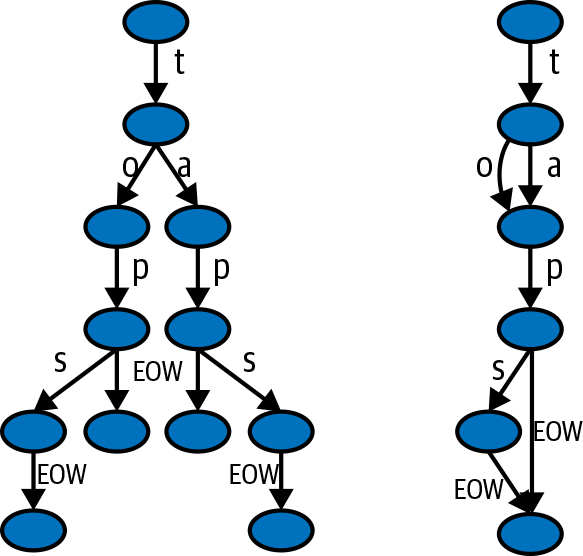

在下面的部分中，我们将更详细地了解DAWGs, Tries及其用法。

### 有向无环图

有向无环字图（MIT许可证）试图有效地表示共享公共前缀和后缀的字符串。

请注意，必须应用GitHub上的 open Pull 请求才能使这个 DAWG 与 python3.7 一起工作。

在下面示例中，可以看到一个非常简单的设置。对于本实施后不能修改DAWG；它读取一个迭代器来构造自己一次。对于用例来说，缺少构建后更新可能会破坏交易。如果是这样，可能需要考虑改用 Trie。DAWG确实支持丰富的查询，包括前缀查找；它还允许持久性，并支持将整数索引与字节和记录值一起存储为值。

例：使用DAWG存储数据

正如你在下面例子中看到的，对于同一组串，其使用的RAM明显少于先前的设置示例。更相似的输入文本将导致更强的压缩。

例：运行DAWG示例

更重要的是，如果我们将 DAWG 持久化到磁盘，如下面示例所示，然后将其加载回一个新的 Python 实例中，我们看到 RAM 使用量显著减少了磁盘文件和加载后的内存使用量都是 70MB；与我们之前构建的 1.2GB 设置变体相比，这是一个显著的节约！

例：加载在早期会话中构建并保存的DAWG更高效

假设您通常只创建一次DAWG，然后多次加载它，那么在将结构持久化到磁盘之后，您将从重复的构建成本中获益。

### MARISA TRIE

Marisa Trie（双许可LGPL和BSD）是一个静态 Trie，使用Cython绑定到外部库。因为它是静态的，所以在构建之后不能修改。与DAWG一样，它支持将整数索引存储为值，以及字节值和记录值。

键可用于查找值，反之亦然。可以有效地找到共享相同前缀的所有密钥。Trie的内容可以持久化。下面例子演示了如何使用 Marisa Trie 来存储我们的样本数据。

例：使用Marisa Trie存储数据

在下面示例中，我们可以看到查找时间比DAWG提供的要慢。

例：运行Marisa Trie示例

Trie 进一步节省了这个数据集的内存。而在下面示例中，查找速度稍微慢一点，在下面的代码片段中，磁盘和RAM的使用量大约为30MB，如果我们将trie保存到磁盘，然后将其加载回一个新的进程中；这是道格成就的两倍。

例：加载在早期会话中构建并保存的 Trie 更高效

对于应用程序，需要研究构造后的存储大小和查找时间之间的权衡。可能会发现，使用其中一个“效果很好”，因此可能会避免基准测试其他选项，而只是继续进行下一个挑战。在这种情况下，我们建议首选Marisa Trie；它比GitHub上的五星还要多。

### 在生产系统中使用TRIES（和DAWG）

Trie 和 DAWG 数据结构提供了很好的好处，但是仍然必须针对你的问题对它们进行基准测试，而不是盲目地采用它们。如果你的字符串中有重叠的序列，可能会看到RAM的改进。

Tries和dawg不太为人所知，但它们可以在生产系统中提供强大的优势。在“Smesh大型社交媒体分析（2014）”中有一个成功案例。DabApps（一家位于英国的Python软件公司）的Jamie Matthews还讲述了如何在客户机系统中使用 Tries 来为客户实现更高效、更廉价的部署：

DAWG 和 Tries是功能强大的数据结构，可以帮助节省RAM和时间，以换取一点额外的准备工作。对于许多开发人员来说，这些数据结构是不熟悉的，所以考虑将这些代码分离成一个模块，该模块与代码的其余部分合理地隔离开来，以简化维护。

# 使用 Scikit Learn 的 FeatureHasher 建模更多文本

Scikit Learn 是 Python 最著名的机器学习框架，它对基于文本的自然语言处理（NLP）挑战有极好的支持。在这里，我们将把公共帖子从Usenet档案分类为20个预先指定的类别之一；这类似于清理电子邮件收件箱的两类垃圾邮件分类过程。

文本处理的一个困难是被分析的词汇迅速膨胀。英语使用许多名词（如人名、地名、医学标签和宗教术语）和动词（经常以“-ing”结尾的“分词”，如“跑”、“拿”、“做”和“说”）及其变位（将动词“talk”变成“talked”、“talking”、“talks”），以及其他丰富的语言形式。标点符号和大写给单词的表达增加了额外的细微差别。

对文本进行分类的一种强大而简单的技术是将原始文本分成n个g，通常是unigram、bigram和trigram（也称为1-gram、2-gram和3-gram）。像“有一只猫和一只狗”这样的句子可以变成单字（“有”，“是”，“a”，等等），大字（“有”，“是”，“一只猫”，等等）和三角形（“有”，“是一只猫”，“一只猫和…”）。

这句话有7个单字，6个大字和5个三角形；总的来说，这句话可以用6个独特的单字（因为“a”这个词用了两次）、6个独特的二元结构和5个独特的三元结构来表示，总共有17个描述性项目。如你所见，用来表示一个句子的 N-Gram 词汇迅速增长；有些术语非常常见，有些则非常罕见。

有一些技术可以控制词汇表的爆炸性增长，例如消除停止词（删除最常见且通常不具信息性的术语，如“a”、“the”和“of”）、将所有内容小写以及忽略不太常见的术语类型（如标点符号、数字和方括号）。如果练习自然语言处理，很快就会遇到这些方法。

## 介绍DictVectorizer和FeatureHasher

在我们研究Usenet分类任务之前，让我们先看看scikit-learn的两个特性处理工具，它们有助于解决NLP挑战。第一种是DictVectorizer，它获取术语及其频率的字典，并将它们转换为可变宽度的稀疏矩阵（我们将在“SciPy的稀疏矩阵”中讨论稀疏矩阵）。第二个是 FeatureHasher，它将相同的术语和频率字典转换为固定宽度的稀疏矩阵。

下面例子展示了两个句子——“有一只猫”和“有一只猫和一只狗”，其中一个句子中使用了两个术语“a”。DictVectorizer 是在调用中给出句子的fit；在第一个过程中，它将单词列表构建到内部词汇表中，在第二个过程中，它构建一个稀疏矩阵，其中包含对每个术语及其计数的引用。

FeatureHasher 的两个过程比一个过程耗时更长，存储词汇表需要额外的RAM。建立词汇表通常是一个连续的过程；通过避免这一阶段，特性散列可能会并行运行以提高速度。

例：基于DictVectorizer的无损文本表示

In [18]:
from sklearn.feature_extraction import DictVectorizer

In [19]:
dv = DictVectorizer()

In [21]:
# frequency counts for ["there is a cat", "there is a cat and a dog"]
token_dict = [{'there': 1, 'is': 1, 'a': 1, 'cat': 1},
              {'there': 1, 'is': 1, 'a': 2, 'cat': 1, 'and': 1,'dog': 1}]

In [22]:
dv.fit(token_dict)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=True)

In [23]:
print("Vocabulary:")

Vocabulary:


In [25]:
print(dv.vocabulary_)

{'a': 0, 'and': 1, 'cat': 2, 'dog': 3, 'is': 4, 'there': 5}


In [26]:
X = dv.transform(token_dict)

为了使输出更加清晰，请参见图中矩阵X的DataFrame视图，其中列设置为词汇表。请注意，这里我们对矩阵进行了密集表示，我们有2行6列，12个单元格中的每个单元格都包含一个数字。在稀疏形式中，我们只存储存在的10个计数，而不存储丢失的2个项目的任何内容。对于更大的语料库，密集表示（主要包含0）所需的更大存储空间很快变得令人望而却步。对于NLP，稀疏表示是标准的。

数据帧中显示的DictVectorizer的转换输出:

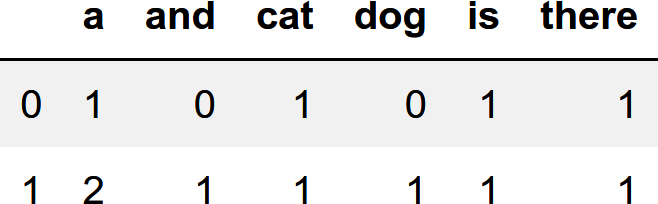

DictVectorizer的一个特点是，我们可以给它一个矩阵并反转过程。在下面示例中，我们使用词汇表来恢复原始频率表示。注意，这并不能恢复原来的句子；在第一个例子中，有不止一种解释单词顺序的方法（“有猫”和“有猫”都是有效的解释）。如果我们使用bigrams，我们会开始在单词的顺序上引入一个约束。

例：将矩阵X的输出反转为原始字典表示

In [27]:
print("Reversing the transform:")

Reversing the transform:


In [28]:
print(dv.inverse_transform(X))

[{'a': 1.0, 'cat': 1.0, 'is': 1.0, 'there': 1.0}, {'a': 2.0, 'and': 1.0, 'cat': 1.0, 'dog': 1.0, 'is': 1.0, 'there': 1.0}]


FeatureHasher接受相同的输入并生成类似的输出，但有一个关键区别：它不存储词汇表，而是使用哈希算法为列分配标记频率。

我们已经在“Dictionaries and set是如何工作的”一文中讨论了散列函数。散列将唯一项（在本例中是文本标记）转换为一个数字，其中多个唯一项可能映射到相同的散列值，在这种情况下，我们会遇到冲突。好的散列函数很少引起冲突。如果我们将许多独特的项散列到一个较小的表示中，冲突是不可避免的。散列函数的一个特性是它不容易反转，因此我们不能获取散列值并将其转换回原始标记。

在下面示例中，我们要求一个固定宽度的10列矩阵，默认值是100万个元素的固定宽度矩阵，但我们将使用一个小矩阵来显示冲突。对于许多应用程序来说，默认的100万元素宽度是一个合理的默认值。

散列过程使用快速的hash3算法，将每个令牌转换成一个数字；然后将其转换为我们指定的范围。较大的射程几乎没有碰撞；像我们10的小范围会有很多碰撞。由于每个标记都必须映射到10列中的一列，因此如果我们添加大量语句，将会发生许多冲突。

输出X有2行10列；每个标记映射到一列，我们不知道哪个列代表每个单词，因为哈希函数是单向的，所以我们不能将输出映射回输入。在这种情况下，我们可以使用额外的 extra_token_dic 推断出那里的令牌和都映射到第8列，因此我们在第8列中得到9个0和1个2的计数。

例：使用10列FeatureHasher显示哈希冲突

In [29]:
from sklearn.feature_extraction import FeatureHasher

In [31]:
import numpy as np
fh = FeatureHasher(n_features=10, alternate_sign=False)
fh.fit(token_dict)
X = fh.transform(token_dict)
print(X.toarray().astype(np.int_))

[[1 0 0 0 0 0 0 2 0 1]
 [2 0 0 1 0 1 0 2 0 1]]


In [32]:
extra_token_dict = [{'there': 1, 'is': 1}, ]
X = fh.transform(extra_token_dict)
print(X.toarray().astype(np.int_))

[[0 0 0 0 0 0 0 2 0 0]]


尽管发生了冲突，但在这种表示中通常保留了足够多的信号（假设使用了默认的列数），与DictVectorizer相比，FeatureHasher能够获得类似质量的机器学习结果。

## 比较DictVectorizer和FeatureHasher

如果我们使用完整的20个新闻组数据集，我们有20个类别，大约18000封电子邮件分布在各个类别中。虽然有些类别如“sci.med”是相对独特的，但其他类别如“comp.os.ms windows.misc”和“comp.windows.x”将包含具有相似术语的电子邮件。机器学习任务是从测试集中每个项目的20个选项中正确识别正确的新闻组。测试集有大约4000封电子邮件；用于学习术语到匹配类别的映射的训练集大约有14000封电子邮件。

请注意，这个例子并没有处理现实训练挑战的一些必要性。我们还没有剥离新闻组元数据，这些元数据可以用来应对这一挑战；一些无关的元数据并不是仅仅从邮件文本中概括出来的，而是人为地提高了分数。我们把邮件随机地乱排了一下。在这里，我们并不是试图获得一个优秀的机器学习结果；相反，我们演示了有损哈希表示可以等价于无损且更需要内存的变体。

在下面示例中，我们获取18846个文档，并使用DictVectorizer和FeatureHasher以及unigrams、bigrams和trigrams构建训练和测试集表示。

DictVectorizer稀疏数组具有训练集的形状（141344335793），其中我们的14134封电子邮件使用400万个令牌表示。建立词汇表和转换训练数据需要42秒。
与FeatureHasher相比，FeatureHasher有一个固定的100万元素范围的散列表示，转换需要21秒。请注意，在这两种情况下，大约980万个非零项存储在稀疏矩阵中，因此它们存储的信息量相似。由于冲突，散列版本存储的项目减少了大约10000个。

如果我们使用密集矩阵，我们将有14000行乘1000万列，使得14000000000个8字节的单元的内存大大超过当前任何机器中通常可用的内存。这个矩阵只有一小部分是非零的。稀疏矩阵避免了这种RAM消耗。

例：比较dictvectorier和FeatureHasher在一个实际机器学习问题上的应用

关键的是，DictVectorizer上使用的LogisticRegression分类器需要花费30%的时间来训练400万列，而FeatureHasher使用的是100万列。两者的得分均为0.89，因此对于这一挑战，结果相当。

使用FeatureHasher，我们在测试集上获得了相同的分数，更快地构建了训练矩阵，避免了构建和存储词汇表，而且我们的训练速度比使用更常见的DictVectorizer方法更快。作为交换，我们已经失去了将散列表示转换回用于调试和解释的原始特性的能力，而且由于我们通常希望能够诊断为什么要做出决策，这对您来说可能太昂贵了。

# SciPy稀疏矩阵

在“介绍DictVectorizer和FeatureHasher”中，我们使用DictVectorizer创建了一个大型特征表示，它在后台使用稀疏矩阵。这些稀疏矩阵也可用于一般计算，在处理稀疏数据时非常有用。

稀疏矩阵是大多数矩阵元素为0的矩阵。对于这些类型的矩阵，有许多方法可以对非零值进行编码，然后简单地说“所有其他值都是零”。除了这些节省内存的方法外，许多算法还具有处理稀疏矩阵的特殊方法，这些方法提供了额外的计算优势：

In [33]:
from scipy import sparse

In [34]:
A_sparse = sparse.random(2048, 2048, 0.05).tocsr()

In [35]:
A_sparse

<2048x2048 sparse matrix of type '<class 'numpy.float64'>'
	with 209715 stored elements in Compressed Sparse Row format>

In [36]:
%timeit A_sparse * A_sparse

10 loops, best of 5: 175 ms per loop


In [37]:
A_dense = A_sparse.todense()

In [38]:
type(A_dense)

<class 'numpy.matrix'>

In [39]:
%timeit A_dense * A_dense

1 loops, best of 5: 175 ms per loop


最简单的实现是针对SciPy中的COO矩阵，对于每个非零元素，除了值的位置之外，我们还存储值。这意味着对于每个非零值，我们总共存储三个数字。只要我们的矩阵至少有66%的零条目，我们就减少了将数据表示为稀疏矩阵所需的内存量，而不是标准的numpy数组。然而，COO矩阵通常仅用于构造稀疏矩阵，而不用于实际计算（因此，CSR/CSC是首选）。

我们可以在图中看到下图对于低密度，稀疏矩阵比密集矩阵快得多。除此之外，它们使用的内存也少得多。

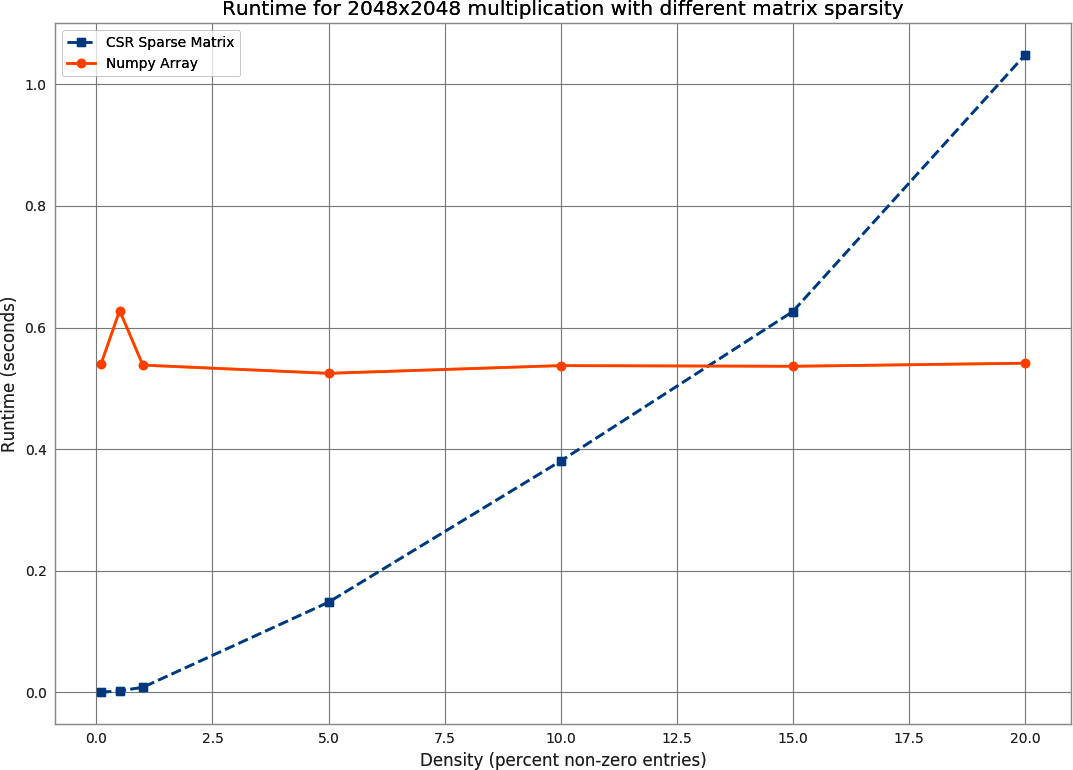

稀疏与密集矩阵乘法

在下图中，密集矩阵始终使用32.7 MB内存（2048 MB）× 2048× 64位）。但是，密度为20%的稀疏矩阵仅使用10MB，节省了70%！随着稀疏矩阵密度的增加，numpy在速度方面迅速占据主导地位，因为它具有矢量化和更好的缓存性能。

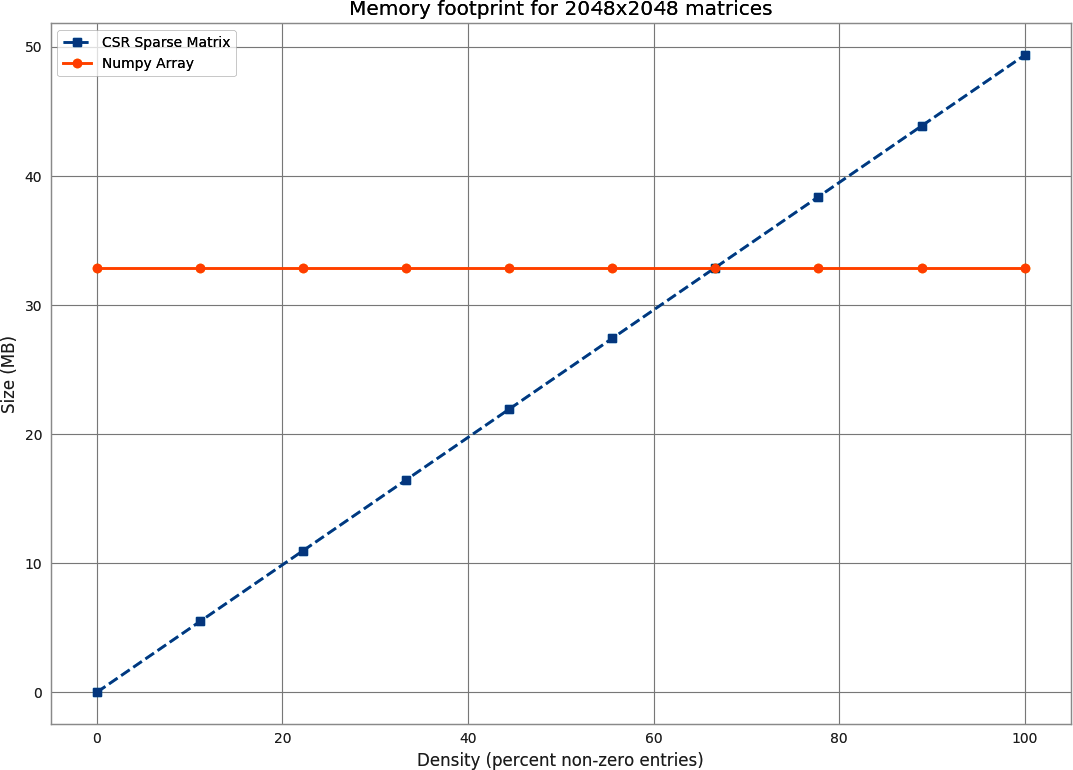

稀疏与密集内存占用

内存使用的极度减少是速度如此之快的部分原因。除了只对非零的元素执行乘法运算（从而减少所需的运算次数），我们也不需要分配如此大的空间来保存结果。这是稀疏数组加速的推拉，它是失去高效缓存和矢量化与不必进行大量与矩阵零值相关的计算之间的平衡。

稀疏矩阵特别擅长的一种运算是余弦相似。事实上，在创建DictVectorizer时，正如我们在“介绍DictVectorizer和FeatureHasher”中所做的那样，通常使用余弦相似性来查看两段文本的相似程度。一般来说，对于这些逐项比较（将一个特定矩阵元素的值与另一个矩阵元素的值进行比较），稀疏矩阵做得很好。由于无论使用普通矩阵还是稀疏矩阵，对numpy的调用都是相同的，因此我们可以在不更改算法代码的情况下对使用稀疏矩阵的好处进行基准测试。

虽然这令人印象深刻，但也存在严重的局限性。稀疏矩阵的支持量非常低，除非运行特殊的稀疏算法或只执行基本操作，否则在支持方面可能会遇到困难。此外，SciPy的稀疏模块提供了稀疏矩阵的多种实现，所有这些实现都有不同的优点和缺点。了解哪一个是最好的使用方法以及何时使用它需要一些专家知识，并且常常导致相互冲突的需求。因此，稀疏矩阵可能不是您经常使用的工具，但是当它们是正确的工具时，它们是非常宝贵的。

In [13]:
!pip install scipy

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [16]:
import timeit

import numpy as np
import pylab as py
from scipy import sparse


def benchmark(size=2048):
    densities = np.asarray([0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2])
    results = {"sparse": [], "dense": []}
    for density in densities:
        m_sparse = sparse.random(size, size, density).tocsr()
        m_dense = m_sparse.todense()
        N_sparse, total_time_sparse = timeit.Timer(
            "m_sparse * m_sparse", globals=locals()
        ).autorange()
        N_dense, total_time_dense = timeit.Timer(
            "m_dense * m_dense", globals=locals()
        ).autorange()
        time_sparse = total_time_sparse / N_sparse
        time_dense = total_time_dense / N_dense
        results["sparse"].append(time_sparse)
        results["dense"].append(time_dense)
        print(time_sparse, time_dense)

    fig = py.figure()
    py.plot(
        densities * 100, results["sparse"], "--", marker="s", label="CSR Sparse Matrix"
    )
    py.plot(densities * 100, results["dense"], "-", marker="o", label="Numpy Array")
    py.title(f"Runtime for {size}x{size} multiplication with different matrix sparsity")
    py.ylabel("Runtime (seconds)")
    py.xlabel("Density (percent non-zero entries)")
    py.legend()
    ax = py.gca()
    py.tight_layout()
    py.savefig("sparse_runtime.png")
    py.close(fig)


def matrix_size(size=2028):
    densities = np.linspace(0, 100, 10)
    sparse_size = []
    dense_size = []
    for density in densities:
        m_sparse = sparse.random(size, size, density / 100).tocsr()
        m_dense = m_sparse.todense()

        sparse_size.append(
            (m_sparse.data.nbytes + m_sparse.indices.nbytes + m_sparse.indptr.nbytes)
            / 1e6
        )
        dense_size.append(m_dense.data.nbytes / 1e6)

    fig = py.figure()
    py.plot(densities, sparse_size, "--", marker="s", label="CSR Sparse Matrix")
    py.plot(densities, dense_size, "-", marker="o", label="Numpy Array")
    py.title(f"Memory footprint for {size}x{size} matrices")
    py.ylabel("Size (MB)")
    py.xlabel("Density (percent non-zero entries)")
    py.legend()
    ax = py.gca()
    py.tight_layout()
    py.savefig("sparse_footprint.png")
    py.close(fig)


if __name__ == "__main__":
    matrix_size()
    benchmark()

0.00038201088400001025 0.20872335000001385
0.00357552270999804 0.21098671000004288
0.013235742599999867 0.1894239524999648
0.15415868749994388 0.1998011294999742
0.3208682009999393 0.21095172949992502
0.5924138029999995 0.20218767450000996
0.9842902109999159 0.18053771649999817


# 使用更少内存的技巧

一般来说，如果能避免把它放进RAM，那么就这样做。装载的每件东西都要花费你的内存。可以只加载一部分数据，例如，使用内存映射文件；或者，可以使用生成器只加载部分计算所需的部分数据，而不是一次全部加载。

如果使用的是数字数据，那么几乎肯定会希望切换到使用numpy数组——该包提供了许多直接处理底层基本对象的快速算法。与使用数字列表相比，RAM的节省是巨大的，而且时间的节省也是惊人的。此外，如果处理的是非常稀疏的数组，那么使用SciPy的稀疏数组功能可以节省难以置信的内存量，尽管与普通numpy数组相比，它的特性集减少了。

如果使用的是字符串，请坚持使用str而不是bytes，除非有充分的理由在byte级别工作。手工处理大量的文本编码是很痛苦的，UTF-8（或其他Unicode格式）往往会使这些问题消失。如果要在静态结构中存储许多Unicode对象，可能需要研究我们刚才讨论的DAWG和 Trie结构。

如果正在处理大量位字符串，请研究numpy和bitarray包；两者都有有效的字节表示。还可以从Redis中获益，它提供了位模式的高效存储。

PyPy项目正在尝试更有效地表示同构数据结构，因此PyPy中相同基元类型的长列表（例如整数）的成本可能比CPython中的等效结构低得多。任何使用嵌入式系统的人都会对MicroPython项目感兴趣：这个Python的微小内存占用实现旨在实现python3兼容性。

它（几乎！）不用说，知道当试图优化RAM使用时，必须进行基准测试，而且在进行算法更改之前，有一个单元测试套件是值得的。

# 研究项目：概率数据结构

# 思考题

本节结束后您将能够回答的问题
- 我为什么要少用内存？
- 为什么numpy和array更适合存储大量的数字？
- 如何在RAM中高效地存储大量的文本？
- 我如何大约只用一个字节计数$10^{78}$？